# Données slitless CTIO

In [1]:
# %matplotlib notebook
%matplotlib inline

In [52]:
from __future__ import print_function     #bug 1: I moved this one, gotta remove this cheat, right ?

import numpy as N
import matplotlib.pyplot as P

import scipy.interpolate as SI

import astropy.io.fits as F
import astropy.nddata as AN
import astropy.modeling as AM
import astropy.visualization as AV

In [3]:
P.rcParams['figure.figsize'] = (10, 6)
P.rcParams['image.origin'] = True

# import mpld3
# mpld3.enable_notebook()

## HD111980 (20170530_130)

This exposure was done w/ a Ronchi dispersor, hence the strong defocus in the red part. 

In [6]:
hdu = F.open("reduc_20170530_130.fits")                 #There's no close ? 
hdu.info()                                               #context manager with fits.open(fits_image_filename) as hdul:

Filename: reduc_20170530_130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     134   (2048, 2048)   float64   


In [7]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBJECT  = 'HD11980 '           / Name of object observed                        
OBSERVER= '        '           / observer                                       
PROPID  = '        '           / Proposal ID                                    
RECID   = 'ct36.20170531.024522' / NOAO Archibe record ID                       
PROPID  = '        '           / Proposal ID                                    
IMAGETYP= 'object  '        

In [8]:
# fima = N.ma.masked_greater(hdu[0].data, 65000)  # full image, masked
fima = hdu[0].data  # full image

### Background subtraction

In [9]:
center = (1255, 680)  # x, y
size = (49, 1209)     # dy, dx

ima = AN.Cutout2D(fima, center, size, copy=True)         # Cutout image
bkg = AN.Cutout2D(fima, center, (size[0] * 4, size[1]))  # Larger cutout for background estimate

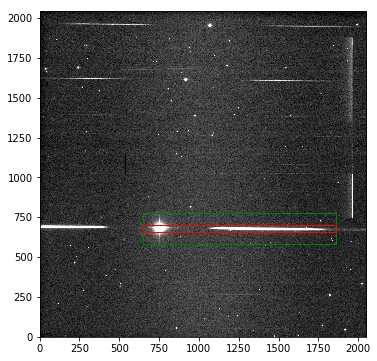

In [10]:
fig, ax = P.subplots(1, 1)
ax.imshow(fima, cmap='gray', 
          norm=AV.ImageNormalize(fima, interval=AV.PercentileInterval(99)))
bkg.plot_on_original(ax, color='green')
ima.plot_on_original(ax, color='red');

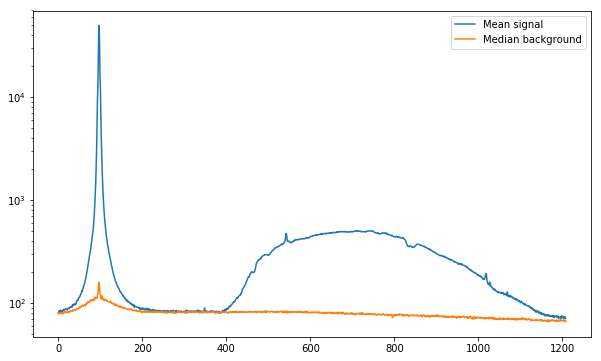

In [11]:
medbkg = N.ma.median(bkg.data, axis=0)              # Median 1D background

fig, ax = P.subplots(1, 1)
ax.plot(ima.data.mean(axis=0), label="Mean signal")  # X-disp. 1D sum 
ax.plot(medbkg, label='Median background')
ax.set_yscale('log')
ax.legend();

In [12]:
ima.data -= medbkg  # Median background subtraction

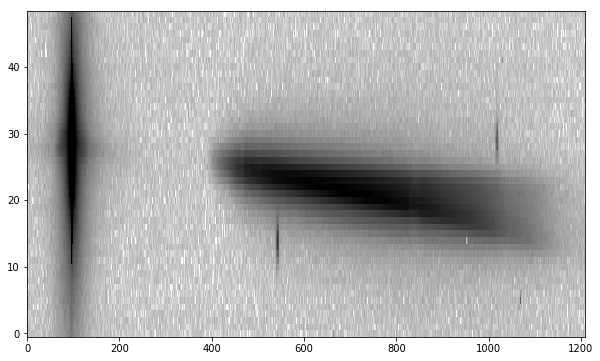

In [13]:
fig, ax = P.subplots(1, 1)
im = ax.imshow(ima.data, cmap='gray_r', 
               norm=AV.ImageNormalize(ima.data, interval=AV.PercentileInterval(99), stretch=AV.LogStretch()))
ax.set_aspect('auto');

In [14]:
spec = ima.data.sum(0)  # Cross-dispersion sum

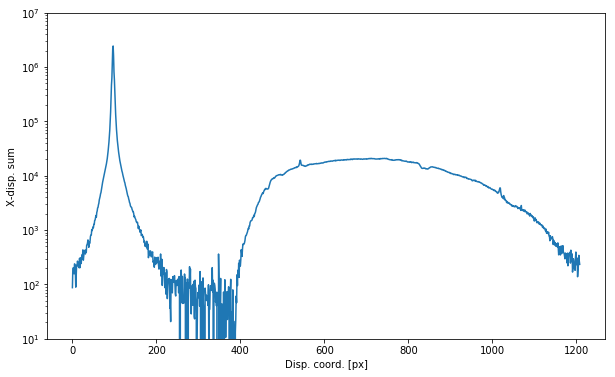

In [15]:
fig, ax = P.subplots(1, 1)
ax.plot(spec)
ax.set(yscale='log', ylim=[1e1, 1e7], ylabel='X-disp. sum', xlabel='Disp. coord. [px]');

### Spectral trace

#### 0th-order

In [16]:
xf0, yf0 = 748.005, 684.256                  # J. Neveu estimate in full image
x0, y0 = ima.to_cutout_position((xf0, yf0))  # Position in cutout
print("0th-order position (cutout):", x0, y0)

0th-order position (cutout): 97.005 28.255999999999972


#### 1st-order

In [18]:
thetadeg = -0.719                         # Rotation [degree] (see below)
lmin, lmax = 325., 1086.                  # Wavelength coverage [nm] (see below)

# Curvilinear offset wrt 0th-order along tilted spectral trace [px]
fds, flbda = N.loadtxt('dispersion_relation.txt', unpack=True)
sel = (flbda >= lmin) & (flbda <= lmax)
lbda = flbda[sel]                                                       #wtf ?? flbda[True] ??? kinda if ? Pourquoi 
print("Spectral coverage: {:.1f}--{:.1f} nm".format(lbda[0], lbda[-1]))              #comment on print "{" du coup ?
                                                                                
# Cartesian x- and y-offsets wrt 0th-order [px]
dx = fds[sel] * N.cos(N.radians(thetadeg))
dy = fds[sel] * N.sin(N.radians(thetadeg))
print("Cartesian offset wrt 0th-order: ({:+.1f},{:+.1f})--({:+.1f},{:+.1f}) px".format(dx[0], dy[0], dx[-1], dy[-1]))

Spectral coverage: 325.7--1085.9 nm
Cartesian offset wrt 0th-order: (+302.0,-3.8)--(+1107.9,-13.9) px


#### Wavelength solution

In [19]:
lbdaofx = SI.InterpolatedUnivariateSpline(dx + x0, lbda)  # Wavelength [nm] as a function of x-position in cutout
xoflbda = SI.InterpolatedUnivariateSpline(lbda, dx + x0)  # X-position in cutout as a function of wavelength [nm]

#### X-dispersion profile

In [20]:
y = N.arange(ima.shape[0])  # X-disp. coordinate [px]
z = ima.data[:, 600]        # X-disp. profile                #Why 600 ? vois pas a quoi ça correspond du coup
print("Total flux:", z.sum())

Total flux: 17780.263211400994


In [21]:
fitter = AM.fitting.LevMarLSQFitter()
gauss = AM.models.Gaussian1D(amplitude=z.max(), mean=z.argmax(), stddev=2)
gfit = fitter(gauss, y, z)
print(fitter.fit_info['message'])
print(gfit)
print("Total flux: {} ({:.2%} error)".format(gfit(y).sum(), gfit(y).sum()/z.sum() - 1))

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
    ----------------- ------------------ ------------------
    4190.510142321903 22.897211847060973 1.5392913100225976
Total flux: 16168.794744309831 (-9.06% error)


**WARNING:** analytic derivatives of Moffat1D in astropy.modeling (2.0.9 and 3.0.5) are wrong (see issue https://github.com/astropy/astropy/issues/8094 ).

In [22]:
moffat = AM.models.Moffat1D(amplitude=z.max(), x_0=z.argmax(), gamma=3, alpha=2)
mfit = fitter(moffat, y, z, estimate_jacobian=True)  # Workaround to issue #8094
print(fitter.fit_info['message'])
print(mfit)
print("Total flux: {} ({:.2%} error)".format(mfit(y).sum(), mfit(y).sum()/z.sum() - 1))

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
Model: Moffat1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0               gamma              alpha      
    ----------------- ------------------ ------------------ -----------------
    4386.936307586843 22.887434087381305 2.6015236725589057 2.066102607639578
Total flux: 17479.37715987584 (-1.69% error)


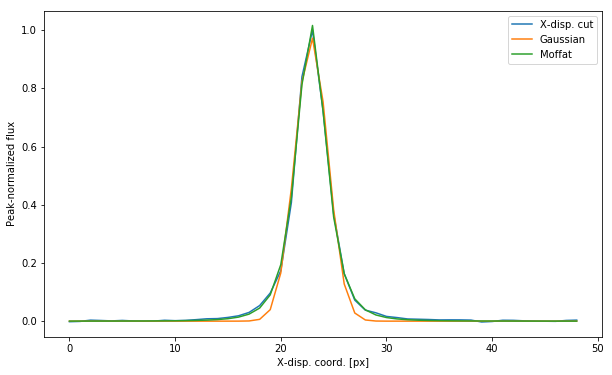

In [23]:
fig, ax = P.subplots(1, 1)
ax.plot(y, z / z.max(), label="X-disp. cut")
lg, = ax.plot(y, gfit(y) / z.max(), label="Gaussian")
lm, = ax.plot(y, mfit(y) / z.max(), label="Moffat")
ax.set(xlabel="X-disp. coord. [px]", ylabel="Peak-normalized flux")
ax.legend();

In [24]:
xs = N.arange(390, 1209, 5)  # Linearly sampled dispersion offset [px]
parameters = N.array([ fitter(gauss, y, ima.data[:, x]).parameters for x in xs ])  # amplitude, mean, stddev
# parameters = N.array([ fitter(moffat, y, ima.data[:, x], estimate_jacobian=True).parameters 
#                        for x in xs ])                                              # amplitude, x_0=mean, gamma=sigma, alpha=beta

amplitudes = parameters[:, 0]
yoffsets = parameters[:, 1] - y0  # X-disp. offset wrt 0th-order [px]
sigmas = parameters[:, 2]         # Sigma [px]

fluxes = amplitudes * sigmas * N.sqrt(2 * N.pi)

#### Effective wavelength coverage

In [25]:
fmin = 0.01                                  # Minimal flux fraction
lsel = fluxes >= (fmin * fluxes.max())
xmin, xmax = xs[lsel][0], xs[lsel][-1]
lmin, lmax = lbdaofx([xmin, xmax])
print("{:.0%}-range: {}--{} px = {:.1f}--{:.1f} nm".format(fmin, xmin, xmax, lmin, lmax))

1%-range: 400--1205 px = 326.8--1086.0 nm


In [26]:
fxofl = SI.InterpolatedUnivariateSpline(lbdaofx(xs), fluxes)#POURQUOI interpol(encore-1param-alor-qu'ona-deja-interpolé)
 #est ce que c'est genre le pas ?  # Et ça en gros ça rescalde l'abscisse car pas dispersé uniformément, right ?

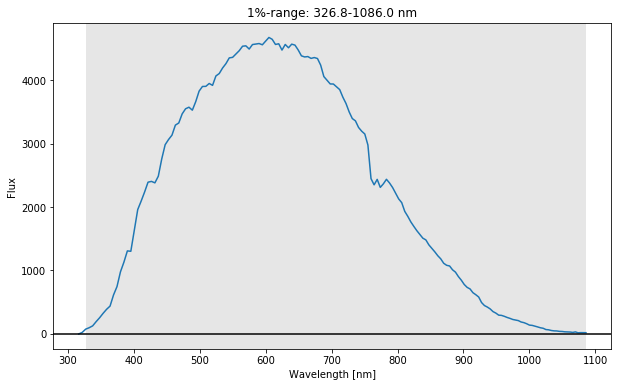

In [27]:
fig, ax = P.subplots(1, 1)
ax.plot(lbdaofx(xs), amplitudes)
#ax.plot(lbda, fxofl(lbda))
ax.axhline(fmin, color='k')
ax.axvspan(lbdaofx(xmin), lbdaofx(xmax), fc='0.9')
ax.set(xlabel="Wavelength [nm]", ylabel="Flux", 
       title="{:.0%}-range: {:.1f}-{:.1f} nm".format(fmin, lmin, lmax));

#### Linear tilt angle

In [28]:
from astropy.stats import sigma_clip
robust_fitter = AM.fitting.FittingWithOutlierRemoval(fitter, sigma_clip, niter=3, sigma=3.0)

Tilt angle: -0.705 deg


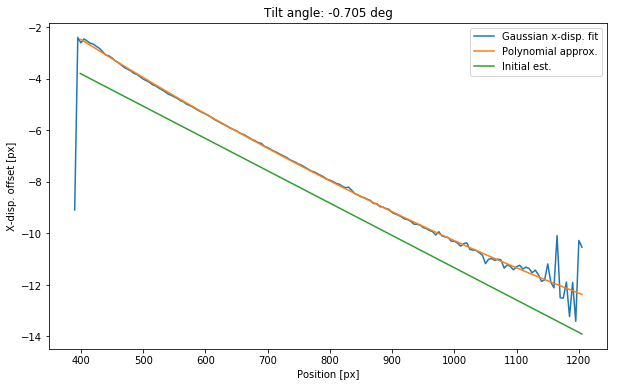

In [29]:
# Robust linear adjustment
# _, dyofx = robust_fitter(AM.models.Linear1D(), xs[lsel], yoffsets[lsel])
# Robust quadratic adjustment
dyofx, _ = robust_fitter(AM.models.Legendre1D(2), xs[lsel], yoffsets[lsel])            #bug 2: pas _, dyofx
ys = dyofx(xs)
theta = N.arctan2(N.diff(ys[lsel]), N.diff(xs[lsel])).mean()
print("Tilt angle: {:.3f} deg".format(N.degrees(theta)))

fig, ax = P.subplots(1, 1)
ax.plot(xs, yoffsets, label='Gaussian x-disp. fit')
ax.plot(xs[lsel], dyofx(xs[lsel]), label='Polynomial approx.')
ax.plot(xoflbda(lbda), dy, label="Initial est.")
ax.set(xlabel="Position [px]", ylabel="X-disp. offset [px]", 
       title="Tilt angle: {:.3f} deg".format(N.degrees(theta)))
ax.legend();

**NOTE:** there's a one px offset between Jeremy's and present cross-dispersion position.

#### X-disp. width

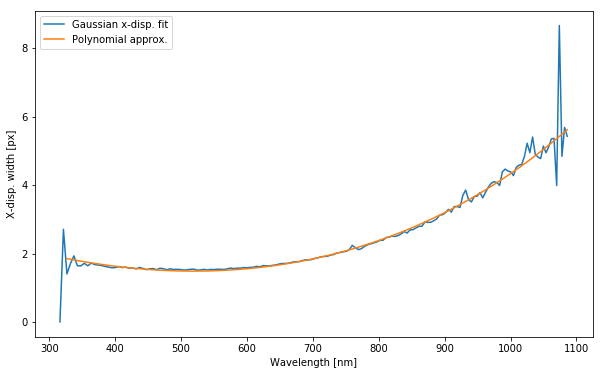

In [30]:
sigofx, _ = robust_fitter(AM.models.Legendre1D(2), xs[lsel], sigmas[lsel])               #bug 3: same

fig, ax = P.subplots(1, 1)
ax.plot(lbdaofx(xs), sigmas, label='Gaussian x-disp. fit')
ax.plot(lbdaofx(xs[lsel]), sigofx(xs[lsel]), label="Polynomial approx.")
ax.set(xlabel="Wavelength [nm]", ylabel="X-disp. width [px]")
ax.legend(); 

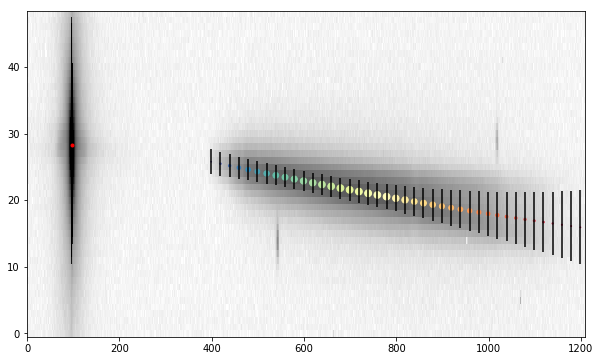

In [31]:
newdy = dyofx(xoflbda(lbda))  # X-disp. offset [px]
sig = sigofx(xoflbda(lbda))   # X-disp. width [px]

fig, ax = P.subplots(1, 1)
ax.imshow(ima.data, cmap='gray_r', 
          norm=AV.ImageNormalize(ima.data, interval=AV.PercentileInterval(99.5), stretch=AV.LogStretch()))
ax.plot([x0], [y0], 'r.')
ax.scatter(x0 + dx[::20], y0 + newdy[::20], c=lbda[::20], s=fxofl(lbda[::20]) / 100, marker='.', cmap='Spectral_r')
ax.errorbar(x0 + dx[::20], y0 + newdy[::20], yerr=sig[::20], fmt='none', c='k')
ax.set_aspect('auto');

### Spectral model

#### PSF model

In [32]:
import slitless.fourier as S
print("Submodules: {}".format(', '.join([ x for x in dir(S) if not x.startswith('__') ])))

Submodules: arrays, fourier, misc, models, pkg, plots, wfc3


In [33]:
nima = size[0]
nlbda = len(lbda)
print("2D spectrum shape: {} × {}".format(nima, nlbda))

y, x = S.arrays.create_coords((nima, nima), starts='auto')

2D spectrum shape: 49 × 807


In [34]:
sigofl, _ = robust_fitter(AM.models.Legendre1D(2), lbdaofx(xs[lsel]), sigmas[lsel])
sigs = sigofl(lbda)

psf = S.models.build_cube(x, y, AM.models.Gaussian2D,
                         x_stddev=sigs, y_stddev=sigs)
print("PSF cube shape: {}".format(psf.shape))
print("Normalized:", N.allclose(psf.sum(axis=(-1, -2)), 1))

PSF cube shape: (807, 49, 49)
Normalized: True


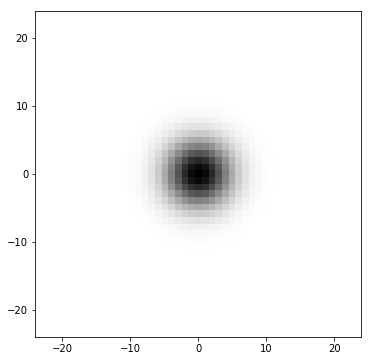

In [35]:
P.imshow(psf[600], extent=(x[0, 0], x[0, -1], y[0, 0], y[-1, 0]), cmap='gray_r');

#### Dispersion law

In [36]:
disp = dx + 1j * newdy  # Dispersion law
odisp = int(disp.real.mean()) + 1j * int(disp.imag.mean())
print("Reference dispersion position: {0.real:+.0f} × {0.imag:+.0f} px".format(odisp))
cdisp = disp - odisp    # Centered dispersion law

Reference dispersion position: +704 × -7 px


#### Simulated spectrum

In [37]:
dima = S.models.disperse_cube(psf, fxofl(lbda), cdisp)
print("Simulated dispersed image:", dima.shape)

Simulated dispersed image: (49, 807)


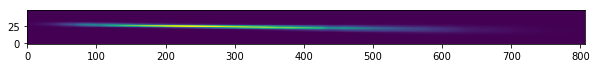

In [38]:
P.imshow(dima)

In [39]:
# Observed and simulated extracted spectral trace
oima = AN.Cutout2D(ima.data, (x0 + odisp.real, y0 + odisp.imag), (nima, nlbda), mode='partial', fill_value=0)
sima = AN.Cutout2D(ima.data, (x0 + odisp.real, y0 + odisp.imag - 2), (nima, nlbda), mode='partial', copy=True)
sima.data = dima
print("Extracted dispersed image:", sima.shape)

Extracted dispersed image: (49, 807)


**BUG:** why a x-disp. offset of ~2 px???

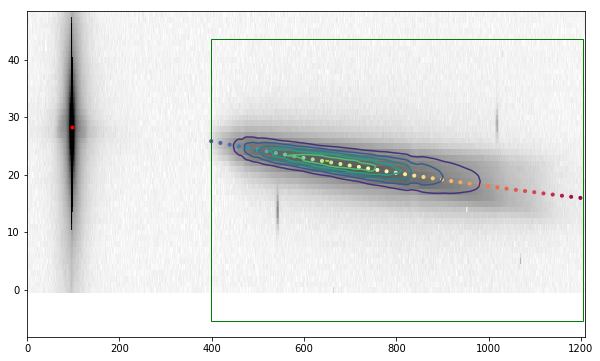

In [40]:
fig, ax = P.subplots(1, 1)
ax.imshow(ima.data, cmap='gray_r', 
          norm=AV.ImageNormalize(ima.data, interval=AV.PercentileInterval(99.5), stretch=AV.LogStretch()))
ax.plot([x0], [y0], 'r.')
ax.scatter(x0 + disp.real[::20], y0 + disp.imag[::20], c=lbda[::20], marker='.', cmap='Spectral_r')
sima.plot_on_original(ax, color='green');
bbox = sima.bbox_original  # ((x, y) lower left, (x, y) upper right)
ax.contour(sima.data, extent=(bbox[1][0], bbox[1][1], bbox[0][0], bbox[0][1]))
ax.set_aspect('auto');

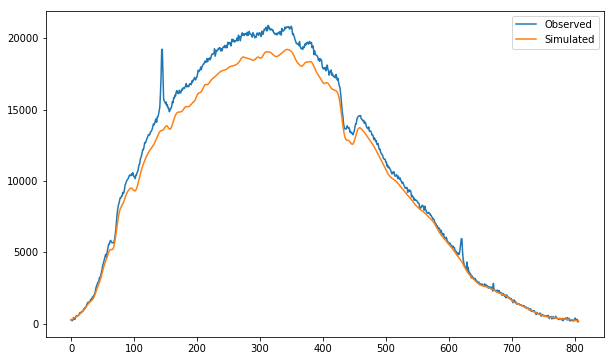

In [41]:
fig, ax = P.subplots(1, 1)
ax.plot(oima.data.sum(axis=0), label='Observed')
ax.plot(sima.data.sum(axis=0), label='Simulated')
ax.legend();

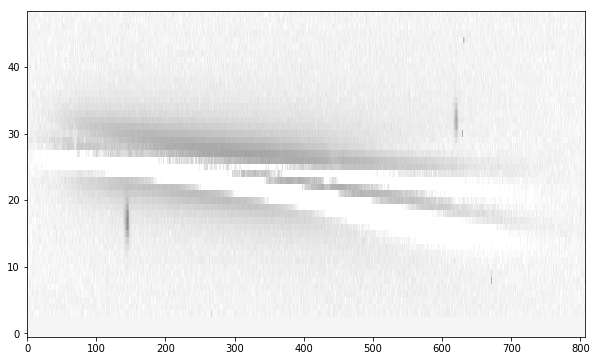

In [42]:
fig, ax = P.subplots(1, 1)
resima = oima.data - sima.data
ax.imshow(resima, cmap='gray_r', 
          norm=AV.ImageNormalize(ima.data, interval=AV.PercentileInterval(99.5), stretch=AV.LogStretch()))
ax.set_aspect('auto');

# Appendix

## Moffat profile

The Moffat (1969A&A.....3..455M) profile is defined as:
$$
M(r) = \frac{\beta - 1}{\pi\alpha^2}\left(1 + \frac{r^2}{\alpha^2}\right)^{-\beta}
$$
Note this form is a reparameterisation of an uncorrelated bivariate Student distribution. As written, the axisymmetric PSF is flux normalized: $\int_0^{\infty} M(r)\,2\pi r\,\mathrm{d}r = 1$. The FWHM is $2\alpha\sqrt{2^{1/\beta} - 1}$.

**WARNING: this normalization needs to be checked (both in 1D and 2D). See [here](https://nbviewer.jupyter.org/github/ysbach/AO_2017/blob/master/04_Ground_Based_Concept.ipynb#1.2.-Moffat).**

The Fourier transform is (TBC):
$$
\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{+\infty} (1 + x^2)^{-\beta} e^{i \omega x} dx = \frac{2^{1 - \beta} |\omega|^{\beta - 1/2} K_{\beta - 1/2}(\omega)}{\Gamma(\beta)}
$$
where $K_{n}$ is the modified Bessel function of the second kind.

For a generic 2D-linear transformation $C$, the normalized 2D-profile can be written
$$
M(x, y) = \frac{(\beta - 1)|C|^{1/2}}{\pi\alpha^2}\left(1 + \frac{(x y)C{x\choose y}}{\alpha^2}\right)^{-\beta}
$$
E.g. elliptical radius $r^2 = x^2 + \epsilon y^2 + 2\xi\,xy$ corresponds to $C = \begin{pmatrix}1 & \xi \\ \xi & \epsilon\end{pmatrix}$, and $|C| = \epsilon - \xi^2$.